Check Notes - Denoising Diffusiion Probabilistic Models(DDPM)

In [12]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, Subset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, CelebA
from torchvision import transforms
import math
from functools import partial
import torch
from torch import nn,einsum
import torch.nn.functional as F
from einops import rearrange
from einops.layers.torch import Rearrange


In [13]:
##Training code paper replication
def get_loss(self,batch,batch_idx):
  ## to get random timestep for the each image int eh batch thrid step in training algorithm
  ts = torch.randint(0,self.t_range,[batch.shape[0]],device=self.device)
  noise_imgs =[]
  #generate noise , one for each image this folows step 4 of trainign algorithm
  epsilons = torch.randn_like(batch.shape,device=self.device)
  for i in range(len(ts)):
    a_hat = self.alpha_bar(ts[i])
    noise_imgs.append((math.sqrt(a_hat)*batch[i])+(math.sqrt(1-a_hat)*epsilons[i]))
  noise_imgs = torch.stack(noise_imgs,dim=0)
  e_hat = self.forward(noise_imgs,ts) ## pass it through the unet
  loss = nn.functional.mse_loss(e_hat.reshape(-1,self.in_size),epsilons.reshape(-1,self.in_size))
  return loss

In [14]:
## let's implement the sampling code paper replication
def denoise_sample(self,x,t):
  with torch.no_grad():
    if t>1:
      z =torch.randn(x.shape)
    else:
      z=0
    e_hat = self.forward(x,t.view(1).repeat(x.shape[0]))
    pre_scale = 1/math.sqrt(self.alpha(t))
    e_scale = (1-self.alpha(t)) / math.sqrt(1-self.alpha_bar(t))
    post_sigma = math.sqrt(self.beta(t))*z
    x=pre_scale*(x-e_scale*e_hat)+ post_sigma
    return x

### DataSet Loading Module

In [15]:
class DiffSet(Dataset):
    def __init__(self, train, dataset_name):

        ds_mapping = {
            "MNIST": (MNIST, 32, 1),
            "FashionMNIST": (FashionMNIST, 32, 1),
            "CIFAR10": (CIFAR10, 32, 3),
        }

        t = transforms.Compose([transforms.ToTensor()])
        ds, img_size, channels = ds_mapping[dataset_name]
        ds = ds("./data", download=True, train=train, transform=t)

        self.ds = ds
        self.dataset_name = dataset_name
        self.size = img_size
        self.depth = channels

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, item):
        ds_item = self.ds[item][0]

        if self.dataset_name == "MNIST" or self.dataset_name == "FashionMNIST":
            pad = transforms.Pad(2)
            data = pad(ds_item) # Pad to make it 32x32
        else:
            data = ds_item

        data = (data * 2.0) - 1.0 # normalize to [-1, 1].
        return data

### UNET

In [16]:
### addon funcstions that is used to help me build unet
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cast_tuple(t, length = 1):
    if isinstance(t, tuple):
        return t
    return ((t,) * length)

def identity(t, *args, **kwargs):
    return t

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )


In [17]:
class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # Original formula from "Attention is all you need": PE(pos, i) = func(pos / 10000^(i/dim))
        # The following positional encodings are evaluated in log space.
        # Input: (B). Output: (B, dim)
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


In [18]:
# building block modules
# Represents a convolution block with a group normalization layer and an activation function
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

# Each ResnetBlock is composed of two blocks and a residual connection
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            # Add two dimensions to time_emb
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            # Divide the time embedding into two parts along the channel dimension
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)
        h = self.block2(h)

        return h + self.res_conv(x)

class Attend(nn.Module):
    def __init__(
        self,
        dropout = 0.,
    ):
        super().__init__()
        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)


    def forward(self, q, k, v):
        """
        einstein notation
        b - batch
        h - heads
        n, i, j - sequence length (base sequence length, source, target)
        d - feature dimension
        """
        q_len, k_len, device = q.shape[-2], k.shape[-2], q.device
        scale = q.shape[-1] ** -0.5
        # similarity
        sim = einsum(f"b h i d, b h j d -> b h i j", q, k) * scale
        # attention
        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)
        # aggregate values
        out = einsum(f"b h i j, b h j d -> b h i d", attn, v)
        return out

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 4,
        dim_head = 32
    ):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        self.attend = Attend()

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h (x y) c', h = self.heads), qkv)
        out = self.attend(q, k, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)



In [19]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults = (1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels # Image channels
        input_channels = channels

        init_dim = default(init_dim, dim) # Initial dimension of the feature map extracted from the input image
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3) # Convert the input image into a feature map

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # Builds multiples of the initial dimensions, used for the encoder and the decoder
        in_out = list(zip(dims[:-1], dims[1:])) # Builds a map of input-output dimensions for the encoder and the decoder

        block_klass = partial(ResnetBlock, groups = resnet_block_groups) # Initializes the number of groups for Group Normalization

        # time embeddings
        time_dim = dim * 4 # The size of the time embedding
        sinu_pos_emb = SinusoidalPosEmb(dim) # Positional Encodings just like in normal transformer
        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out) # Number of layers (up and downs) in the UNet

        for ind, ((dim_in, dim_out)) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Attention(dim_in),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1] # The dimension of the middle layer of the UNet = 512
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Attention(mid_dim)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, ((dim_in, dim_out)) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Attention(dim_out),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels
        self.out_dim = default(out_dim, default_out_dim) # Channels of the output image

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time):
        # x: [BATCH, CHANNELS, HEIGHT, WIDTH]
        # time: [B]
        x = self.init_conv(x)
        r = x.clone()
        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:

            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            x = attn(x) + x
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x) + x
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:

            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x) + x
            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [20]:
!pip install pytorch-lightning


In [21]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import math

class DiffusionModel(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size

        self.unet = Unet(dim = 64, dim_mults = (1, 2, 4, 8), channels=img_depth)

    def forward(self, x, t):
        return self.unet(x, t)

    def beta(self, t):
        # Just a simple linear interpolation between beta_small and beta_large based on t
        return self.beta_small + (t / self.t_range) * (self.beta_large - self.beta_small)

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        # Product of alphas from 0 to t
        return math.prod([self.alpha(j) for j in range(t)])

    def get_loss(self, batch, batch_idx):
        """
        Corresponds to Algorithm 1 from (Ho et al., 2020).
        """
        # Get a random time step for each image in the batch
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
        noise_imgs = []
        # Generate noise, one for each image in the batch
        epsilons = torch.randn(batch.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        # Run the noisy images through the U-Net, to get the predicted noise
        e_hat = self.forward(noise_imgs, ts)
        # Calculate the loss, that is, the MSE between the predicted noise and the actual noise
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample(self, x, t):
        """
        Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020).
        """
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape)
            else:
                z = 0
            # Get the predicted noise from the U-Net
            e_hat = self.forward(x, t.view(1).repeat(x.shape[0]))
            # Perform the denoising step to take the image from t to t-1
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [22]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import imageio
import glob
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

def sample_gif(model, train_dataset, output_dir) -> None:
    gif_shape = [3, 3]  # The gif will be a grid of images of this shape
    sample_batch_size = gif_shape[0] * gif_shape[1]
    n_hold_final = 100  # How many samples to append to the end of the GIF to hold the final image fixed

    # Generate samples from denoising process
    gen_samples = []
    sampled_steps = []
    # Generate random noise
    x = torch.randn(
        (sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size)
    )
    sample_steps = torch.arange(model.t_range - 1, 0, -1)
    sampled_t = 0
    # Denoise the initial noise for T steps
    for t in tqdm(sample_steps, desc="Sampling"):
        x = model.denoise_sample(x, t)
        sampled_t = t
        gen_samples.append(x)
        sampled_steps.append(sampled_t)
    # Add the final image to the end of the GIF many times to hold it fixed
    for _ in range(n_hold_final):
        gen_samples.append(x)
        sampled_steps.append(sampled_t)

    gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
    gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

    assert gen_samples.shape[0] == len(sampled_steps)

    gen_samples = (gen_samples * 255).type(torch.uint8)
    gen_samples = gen_samples.reshape(
        -1,
        gif_shape[0],
        gif_shape[1],
        train_dataset.size,
        train_dataset.size,
        train_dataset.depth,
    )

    # Add a text to the first image in each grid to indicate the step shown
    def add_text_to_image(image, text):
        black_image = np.zeros_like(image.numpy())
        black_image = Image.fromarray(black_image, "RGB")
        draw = ImageDraw.Draw(black_image)
        font = ImageFont.load_default()
        draw.text((0, 0), text, (255, 255, 255), font=font)
        black_image = torch.tensor(np.array(black_image))
        return black_image

    for i in range(gen_samples.shape[0]):
        gen_samples[i, 0, 0] = add_text_to_image(
            gen_samples[i, 0, 0], f"{sampled_steps[i]}"
        )

    def stack_samples(gen_samples, stack_dim):
        gen_samples = list(torch.split(gen_samples, 1, dim=1))
        for i in range(len(gen_samples)):
            gen_samples[i] = gen_samples[i].squeeze(1)
        return torch.cat(gen_samples, dim=stack_dim)

    gen_samples = stack_samples(gen_samples, 2)
    gen_samples = stack_samples(gen_samples, 2)

    output_file = f"{output_dir}/pred.gif"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    imageio.mimsave(
        output_file, list(gen_samples.squeeze(-1)), format="GIF", duration=20
    )

def train_model(config: dict) -> None:
    # Code for optionally loading model
    pass_version = None
    last_checkpoint = None

    if config['load_model']:
        pass_version = config["load_version_num"]
        last_checkpoint = glob.glob(
            f"./lightning_logs/{config['dataset']}/version_{config['load_version_num']}/checkpoints/*.ckpt"
        )[-1]

    # Create datasets and data loaders
    train_dataset = DiffSet(True, config["dataset"])
    val_dataset = DiffSet(False, config["dataset"])

    train_loader = DataLoader(
        train_dataset, batch_size=config["batch_size"], num_workers=4, shuffle=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config["batch_size"], num_workers=4, shuffle=True
    )

    # Create model and trainer
    if config['load_model']:
        model = DiffusionModel.load_from_checkpoint(
            last_checkpoint,
            in_size=train_dataset.size * train_dataset.size,
            t_range=config["diffusion_steps"],
            img_depth=train_dataset.depth,
        )
    else:
        model = DiffusionModel(
            train_dataset.size * train_dataset.size,
            config["diffusion_steps"],
            train_dataset.depth,
        )

    # Load Trainer model
    tb_logger = pl.loggers.TensorBoardLogger(
        "lightning_logs/",
        name=config["dataset"],
        version=pass_version,
    )

    trainer = pl.Trainer(max_epochs=config["max_epoch"], log_every_n_steps=10, logger=tb_logger)

    # Train model
    trainer.fit(model, train_loader, val_loader)

    return model, train_dataset, trainer.logger.log_dir

def get_config() -> dict:
    return {
        "diffusion_steps": 1000,
        "dataset": "CIFAR10",
        "max_epoch": 10,
        "batch_size": 32,
        "load_model": False,
        "load_version_num": 1,
    }

if __name__ == "__main__":
    config = get_config()
    model, train_ds, output_dir = train_model(config)
    sample_gif(model, train_ds, output_dir)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params | Mode 
--------------------------------------
0 | unet | Unet | 35.7 M | train
--------------------------------------
35.7 M    Trainable params
0         Non-trainable params
35.7 M    Total params
142.839   Total estimated model params size (MB)
339       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
Sampling: 100%|██████████| 999/999 [21:49<00:00,  1.31s/it]


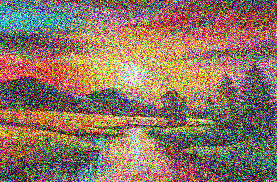

In [24]:
from PIL import Image
import torch
import numpy as np
import math

model = DiffusionModel((277 * 182), 1500, 3)

# How many noise levels to generate
noise_levels = [0, 10, 50, 75, 100, 250, 500, 750, 1000 ,1250,1500]

img = Image.open('/content/image_ddpm.jpg')
img_tensor = torch.tensor(np.array(img))
img_tensor = ((img_tensor / 255.0) * 2.0) - 1.0
# Create a batch by repeating the same image many times
batch = img_tensor.repeat(len(noise_levels), 1, 1, 1)

ts = torch.tensor(noise_levels, dtype=torch.int, device=batch.device)
noise_imgs = []
epsilons = torch.randn(batch.shape, device=batch.device)
# Generate a noisifed version of the image for each noise level
for i in range(len(ts)):
    a_hat = model.alpha_bar(ts[i])
    noise_imgs.append(
        (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
    )


noise_imgs = torch.stack(noise_imgs, dim=0)
noise_imgs = (noise_imgs.clamp(-1, 1) + 1) / 2
noise_imgs = (noise_imgs * 255).type(torch.uint8)

# Convert back to image and display
display_img = Image.fromarray(noise_imgs[5].squeeze(0).numpy(), 'RGB')
display_img

In [28]:
len(noise_imgs)

11

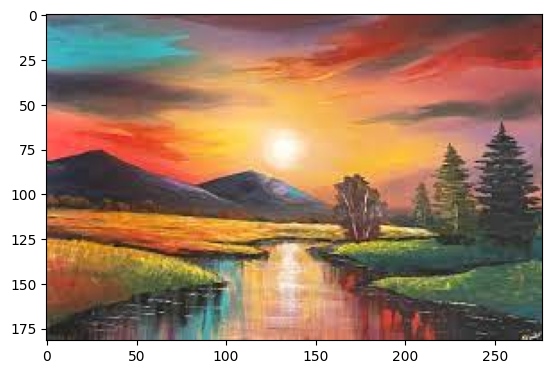

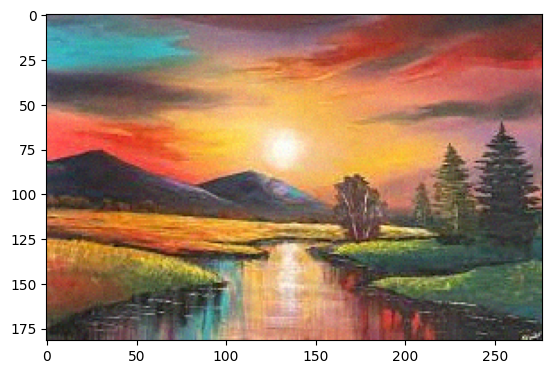

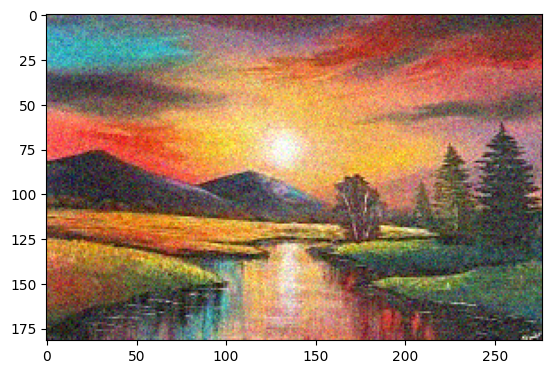

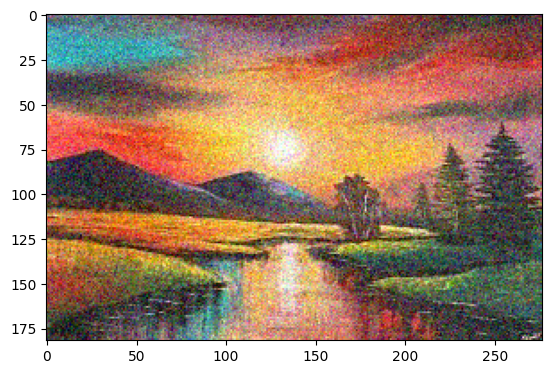

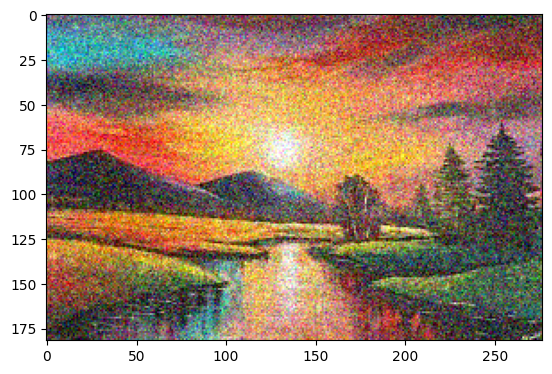

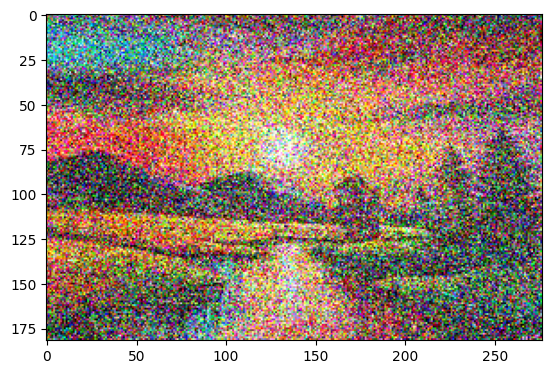

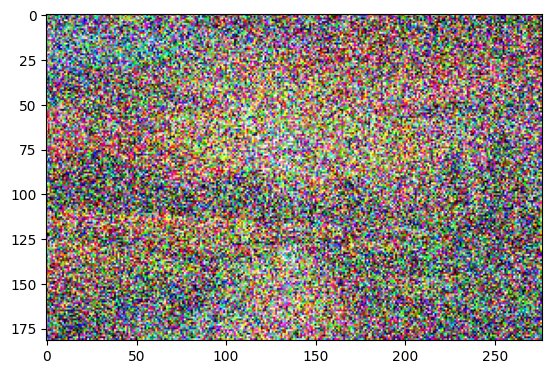

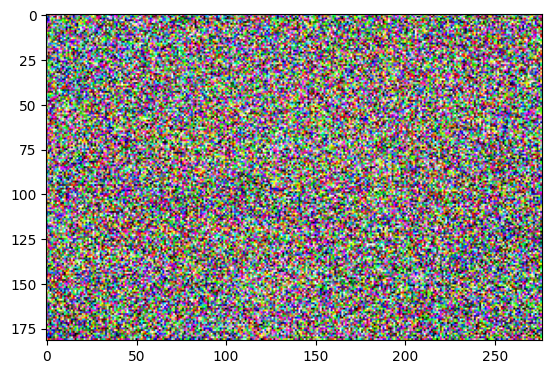

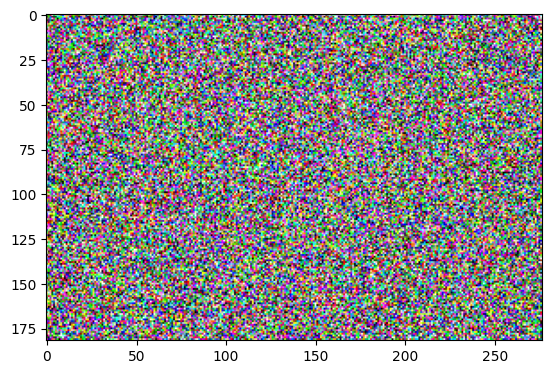

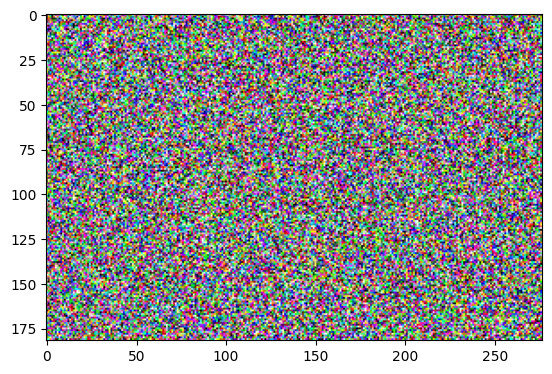

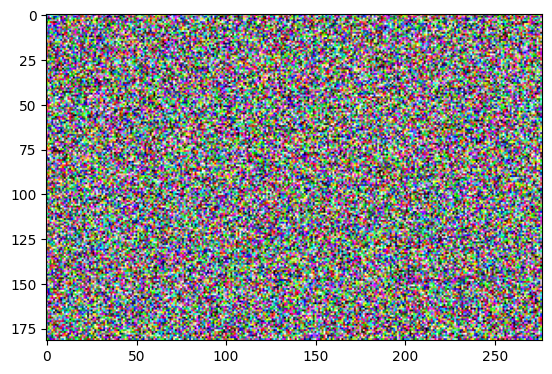

In [31]:
import matplotlib.pyplot as plt
for i in range(len(noise_imgs)):
  display_img = Image.fromarray(noise_imgs[i].squeeze(0).numpy(), 'RGB')
  plt.imshow(display_img)
  plt.show()